In [93]:
# load the locs per project
db_locs = {}
with open('/home/pablo/tesis/tsm-pipeline/experiments/datasets/nosql_1_locs.csv', 'r') as f:
    for l in f.readlines()[1:]:
        l = l.rstrip()
        db_name, locs = l.split(',')
        db_name = db_name.replace('/','_')
        db_locs[db_name] = int(locs)
with open('/home/pablo/tesis/tsm-pipeline/experiments/datasets/xss_1_locs.csv', 'r') as f:
    for l in f.readlines()[1:]:
        l = l.rstrip()
        db_name, locs = l.split(',')
        db_name = db_name.replace('/','_')
        db_locs[db_name] = int(locs)

In [94]:
import re
import datetime as dt
from collections import defaultdict
from dataclasses import dataclass
from typing import Optional

# general imports
import matplotlib.pyplot as plt

# main regex
ts_re = re.compile('\[\w+\t(?P<timestamp>.+)\].+\tdbname=(?P<dbname>[a-zA-Z0-9_\.-]+)\s(?P<msg>.+)$')
# parse timestamp regex
parse_ts = lambda ts: dt.datetime.strptime(ts, '%Y-%m-%d %H:%M:%S,%f')


@dataclass
class Data:
    start_time: Optional[dt.datetime] = None
    end_time: Optional[dt.datetime] = None
    
    def pipeline_time(self):
        if self.start_time == None or self.end_time == None:
            return -1
        return (self.end_time - self.start_time) / dt.timedelta(milliseconds=1)

# main parse line func
def parse_line(l: str):
    ts_groups = ts_re.match(l).groupdict()
    return parse_ts(ts_groups['timestamp']), ts_groups['dbname'], ts_groups['msg']

def parse_logfile(contents: str):
    db_process_info = defaultdict(lambda: Data())
    for l in contents.splitlines():
        l = l.rstrip()
        try:
            ts, dbname, msg = parse_line(l)
        except:
            continue
        data = db_process_info[dbname]
        if msg == 'running pipeline':
            data.start_time = ts
        elif msg == 'run ok':
            data.end_time = ts
    cleaned_times = [
    (k, db_locs[k], db.pipeline_time()) for k,db in db_process_info.items() if db.pipeline_time() > 0
    ]
    # sort by lcos
    cleaned_times.sort(key=lambda c: c[1])
    return cleaned_times

In [95]:
with open("/home/pablo/dev-results/nosql-perf-experiment-1/training_log.txt", 'r') as f:
    cleaned_times_1 = parse_logfile(f.read())
    
with open("/home/pablo/dev-results/nosql-perf-experiment-2/training_log.txt", 'r') as f:
    cleaned_times_2 = parse_logfile(f.read())
    
with open("/home/pablo/dev-results/nosql-perf-experiment-3/training_log.txt", 'r') as f:
    cleaned_times_3 = parse_logfile(f.read())

In [5]:
import numpy as np
import pandas as pd
avg_cleaned_times = []
cleaned_times = [cleaned_times_1, cleaned_times_2, cleaned_times_3]
for i in range(len(cleaned_times_1)):
    dbname = cleaned_times_1[i][0]
    locs = cleaned_times_1[i][2]
    times = [cl[i][2] for cl in cleaned_times]
    avg_cleaned_times.append((dbname, locs, np.average(times), np.std(times)))

In [8]:
pd.DataFrame(avg_cleaned_times, columns=['dbname', 'locs', 'avg', 'stddev'])

,dbname,locs,avg,stddev
0,laurieroy_CampReview_3ee2945,10922,5397.000000,96.512521
1,MiloATH_VotingApp_94e125c,11352,6079.333333,1014.070456
2,18F_checklistomania_9865774,12068,6431.333333,1214.328164
3,Hadh_Cord-System-Photon_293d655,12944,5986.666667,131.286794
4,DanWahlin_CustomerManager_8c42393,13506,6212.333333,57.133372
5,mrvautin_adminMongo_9ab2e98,13777,89784.666667,4932.129110
6,amejiarosario_meanshop_305a189,15224,6348.000000,91.053098
7,MasseyHacks_MasseyHacks-IV-Quill_1c8fbcd,19480,6693.666667,138.874844
8,processing_p5.js-web-editor_3357af6,24210,51451.333333,655.280771
9,DanWahlin_CustomerManagerStandard_8918f51,25772,17318.666667,2918.273957


In [7]:
df = pd.DataFrame(data=[
    [d[2], d[3]] for d in avg_cleaned_times
], columns=['measurement', 'stddev'])
df['std as % of measurement'] = df.apply(lambda r: r['stddev']/r['measurement'], axis=1)
df

,measurement,stddev,std as % of measurement
0,5397.000000,96.512521,0.017883
1,6079.333333,1014.070456,0.166806
2,6431.333333,1214.328164,0.188814
3,5986.666667,131.286794,0.021930
4,6212.333333,57.133372,0.009197
5,89784.666667,4932.129110,0.054933
6,6348.000000,91.053098,0.014344
7,6693.666667,138.874844,0.020747
8,51451.333333,655.280771,0.012736
9,17318.666667,2918.273957,0.168505


In [50]:
# matplotlib globals
# styling tips https://betterdatascience.com/top-3-matplotlib-tips/

from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
from IPython import display
display.set_matplotlib_formats("svg")
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["xtick.labelsize"] = "medium"
plt.rcParams["ytick.labelsize"] = "medium"
plt.style.library['seaborn-paper']

/tmp/ipykernel_371739/1043866552.py:7: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats("svg")
/tmp/ipykernel_371739/1043866552.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.library['seaborn-paper']


RcParams({'axes.labelsize': 8.8,
          'axes.titlesize': 9.6,
          'figure.figsize': [6.4, 4.4],
          'grid.linewidth': 0.8,
          'legend.fontsize': 8.0,
          'lines.linewidth': 1.4,
          'lines.markeredgewidth': 0.0,
          'lines.markersize': 5.6,
          'patch.linewidth': 0.24,
          'xtick.labelsize': 8.0,
          'xtick.major.pad': 5.6,
          'xtick.major.width': 0.8,
          'xtick.minor.width': 0.4,
          'ytick.labelsize': 8.0,
          'ytick.major.pad': 5.6,
          'ytick.major.width': 0.8,
          'ytick.minor.width': 0.4})

Nacho me comentó que una forma simple de probar que el comportamiento entre ambas variables es linear es:
- Hacer una regresión linear sobre las variables
- Medir un tipo de error
- Hacer un p-test sobre los coeficientes de la lineal inferida, y ver que el resultado sea significante
- Despues me dijo que hay algo de probar los supuestos pero es un bardo, esto podría explicarse que ta de más

<Axes: ylabel='runtime [millis]'>

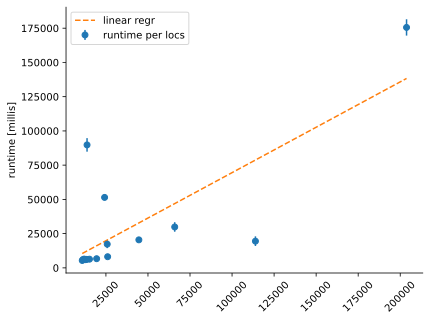

In [97]:
fig = plt.figure()
ax = fig.add_subplot()

x=[c[1] for c in avg_cleaned_times]
y=[c[2] for c in avg_cleaned_times]

m, b = np.polyfit(x,y,1)

ax.errorbar(
    x, 
    y,
    yerr=[c[3] for c in avg_cleaned_times],
    label='runtime per locs', linestyle='none', marker='o')
ax.plot(
    x, 
    m*np.array(x)+b,
    label='linear regr', linestyle='dashed')

# ax.xaxis.set_major_locator(MultipleLocator(1000))

# rotate xticks
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

ax.legend()
ax.set_ylabel('runtime [millis]')
ax

Re-haciendo el mismo análisis para una corrida con 100dbs NoSQL

In [96]:
with open("/home/pablo/dev-results/nosql-perf-experiment-100-run1/training_log.txt", 'r') as f:
    results_nosql_100 = parse_logfile(f.read())
with open("/home/pablo/dev-results/xss-perf-experiment-100-run1/training_log.txt", "r") as f:
    results_xss = parse_logfile(f.read())
pd.DataFrame(results_xss, columns=['dbname', 'locs', 'time'])

,dbname,locs,time
0,ccoenraets_nodecellar_e249ca3,11082,5203.0
1,benas_gamehub.io_e60645f,11380,5517.0
2,Shulkin_far-east-natural-hazards_61663e6,12049,34578.0
3,EvanOxfeld_streams-0.10-presentation_f57d68a,12404,7072.0
4,RetireJS_retire.js_f44bd0a,12675,7164.0
5,Hzy0913_blog-server_913f408,13338,34293.0
6,FullstackAcademy_code-review-starter_42c9405,13362,6730.0
7,ClojureBridge_curriculum_2dbad92,13604,9423.0
8,EPCCed_EPCC-Facilities-Presentation_e4679fb,14688,7261.0
9,Huxpro_css-sucks-2015_481d7f6,16450,8377.0


[ 20962.  67103. 173892. 660428.]


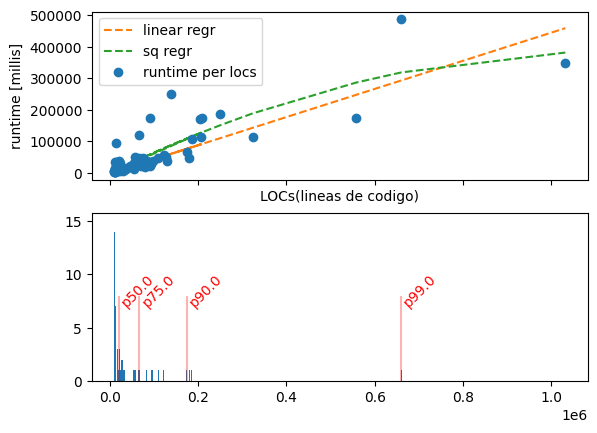

In [97]:
fig, axs = plt.subplots(2,1, sharex=True)
ax = axs[0]
hist = axs[1]

x=[c[1] for c in results_nosql_100 + results_xss]
y=[c[2] for c in results_nosql_100 + results_xss]

m, b = np.polyfit(x,y,1)
m2, m1, b = np.polyfit(x,y,2)

ax.errorbar(
    x, 
    y,
    # yerr=[c[3] for c in avg_cleaned_times],
    label='runtime per locs', linestyle='none', marker='o')
ax.plot(
    x, 
    m*np.array(x)+b,
    label='linear regr', linestyle='dashed')
ax.plot(
    x, 
    m2*(np.array(x) ** 2)+m1*np.array(x)+b,
    label='sq regr', linestyle='dashed')

# ax.xaxis.set_major_locator(MultipleLocator(1000))

# rotate xticks
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

ax.legend()
ax.set_ylabel('runtime [millis]')
ax.set_xlabel('LOCs(lineas de codigo)')

_ = hist.hist(x, bins=(np.max(x) - np.min(x))//1000)

qs = np.array([.5, .75, .9, .99]) * 100
percentiles = np.percentile(x, qs)
print(percentiles)
for i, q in enumerate(qs):
    hist.axvline(x=percentiles[i], ymax=.5, color='red', alpha=.3)
    hist.text(x=percentiles[i], y=7, s=f'p{q}', color='red', rotation=45)

Se me ocurrió tomar por buckets de a 1000 LOCS, entre el mínimo y maximo, el avergae de todos los resultados

In [48]:
def create_locs_buckets(x, size=1000):
    rounded_min = size * (np.min(x) // size)
    print(rounded_min)
    rounded_max = ((np.max(x) // size) + (1 if (np.max(x) % size) != 0 else 0)) * size
    print(rounded_max)
    
    def get_bucket(el):
        return (el - int(rounded_min)) // size
    
    return np.arange(rounded_min, rounded_max, step=size), get_bucket

buckets, get_bucket = create_locs_buckets(x)
indices = np.digitize(x, buckets)
for i in range(len(x)):
    index = indices

10000
207000


array([  1,   1,   1,   1,   1,   2,   2,   2,   2,   2,   2,   2,   3,
         3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   4,
         4,   4,   4,   4,   4,   5,   5,   5,   9,  10,  11,  12,  12,
        12,  13,  14,  16,  20,  20,  28,  29,  46,  47,  56,  56,  74,
       113, 121, 128, 170, 176, 194, 197])